# **Regression Project: Boston House Price Prediction**

# **Marks: 60**

Welcome to the project on regression. We will use the **Boston house price dataset** for this project.

-------------------------------
## **Objective**
-------------------------------

The problem at hand is to **predict the housing prices of a town or a suburb based on the features of the locality provided to us**. In the process, we need to **identify the most important features affecting the price of the house**. We need to employ techniques of data preprocessing and build a linear regression model that predicts the prices for the unseen data.

----------------------------
## **Dataset**
---------------------------

Each record in the database describes a house in Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. Detailed attribute information can be found below:

Attribute Information:

- **CRIM:** Per capita crime rate by town
- **ZN:** Proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS:** Proportion of non-retail business acres per town
- **CHAS:** Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- **NOX:** Nitric Oxide concentration (parts per 10 million)
- **RM:** The average number of rooms per dwelling
- **AGE:** Proportion of owner-occupied units built before 1940
- **DIS:** Weighted distances to five Boston employment centers
- **RAD:** Index of accessibility to radial highways
- **TAX:** Full-value property-tax rate per 10,000 dollars
- **PTRATIO:** Pupil-teacher ratio by town
- **LSTAT:** % lower status of the population
- **MEDV:** Median value of owner-occupied homes in 1000 dollars

## **Importing the necessary libraries**

In [1]:
# Import libraries for data manipulation
import pandas as pd
import numpy as np

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot

# Import libraries for building linear regression model
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Import library for preparing data
from sklearn.model_selection import train_test_split

# Import library for data preprocessing
from sklearn.preprocessing import MinMaxScaler

## Functions to use during EDA

In [2]:
# Global functions.
import matplotlib.patheffects as path_effects
import matplotlib as mpl

suptitle_param = dict(color='darkslategray', weight='bold', fontsize='x-large')

def get_feature_hist_and_boxplot(feature, bins="auto", figsize=(6, 3)):
    """ Boxplot and histogram combined
    feature: pandas.series
    bins: number of bins (default "auto")
    figsize: size of fig (default (6, 3))
    """
    mean = feature.mean()
    median = np.median(feature)
    min_v = feature.min()
    max_v = feature.max()
    
    sns.set(font_scale=.75) 
    f, (ax_box, ax_hist) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid
        sharex=True,  # The X-axis will be shared among all the subplots
        gridspec_kw={"height_ratios": (.25, .75)},
        figsize=figsize
    )

    # Creating the subplots
    # Boxplot will be created and the mean value of the column will be indicated using some symbol
    sns.boxplot(x=feature, ax=ax_box, color='red',
                showmeans=True, 
                meanprops={"marker":"o", 
                           "markerfacecolor":"goldenrod", 
                           "markeredgecolor":"silver", 
                           "markersize":"10"})
    
    text = ax_box.annotate("Mean {:,.4f}".format(mean), fontsize='small',
                           xy=(mean, -0.15), color='g', weight='bold', ha='center')
    text.set_path_effects([path_effects.Stroke(linewidth=3, 
                                               foreground='black'), path_effects.Normal()])
    ax_box.set_ylabel('BoxPlot\n')
    ax_box.set_xlabel('')
    
    # For histogram
    sns.histplot(x=feature, kde=False, bins=bins, ax=ax_hist)
    ax_hist.axvline(mean, color='g', linestyle='--')      # Add mean to the histogram
    ax_hist.axvline(median, color='black', linestyle='-') # Add median to the histogram
    
    min_max_pos = 0.05 * ax_hist.get_ylim()[1]
    text = ax_hist.annotate("Median {:,.4f}".format(median), fontsize='small',
                            xy=(median, ax_hist.get_ylim()[1]/2), 
                            color='w', weight='bold', ha='center')
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='k'), path_effects.Normal()])
    text = ax_hist.annotate("Min {:,.4f}".format(min_v), fontsize='small',
                            xy=(min_v, min_max_pos), 
                            color='w', weight='bold', ha='left')
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='k'), path_effects.Normal()])
    text = ax_hist.annotate("Max {:,.4f}".format(max_v), fontsize='small',
                            xy=(max_v, min_max_pos), 
                            color='w', weight='bold', ha='right')
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='k'), path_effects.Normal()])
    
    ax_hist.set_ylabel('HistPlot')
    ax_hist.set_xlabel('')
    
    # Calculating the skewness
    # If the skewness is between -0.5 & 0.5, the data are nearly symmetrical. 
    # If the skewness is between -1 & -0.5 (negative skewed) or between 0.5 & 1(positive skewed), 
    # the data are slightly skewed. 
    # If the skewness is lower than -1 (negative skewed) or greater than 1 (positive skewed), 
    # the data are extremely skewed.
    skewness = feature.skew()
    if skewness<-1: skewness_str = 'Extremely Negative Skewed'
    elif skewness<-0.5: skewness_str = 'Negative Skewed'
    elif skewness==0: skewness_str = 'Simetrical Distributed'
    elif skewness<=0.5: skewness_str = 'Nearly Simmetrical'
    elif skewness<=1: skewness_str = 'Positive Skewed'
    elif skewness>1: skewness_str = 'Extremely Positive Skewed'
    f.suptitle(f'{feature.name.upper()}\nSkew: {skewness:0.4f} ({skewness_str})', **suptitle_param)
    plt.subplots_adjust(hspace=1, top=0.9)
    plt.tight_layout()

    plt.show()
    plt.style.use('default')

In [3]:
def get_df_correlation(df, tol=0.7):
    """Plot a heatmap of the correlation between numerical variables in df.
    df: dataframe.
    """
    corr = df.corr(numeric_only=True)

    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.set(font_scale=0.75)
    plt.figure(figsize = (10, 6))
    sns.heatmap(corr, annot=True, mask=mask, cmap='vlag')
    plt.title('Correlation between numerical variables', **suptitle_param)
    plt.show()
    plt.style.use('default')
    
    corr = pd.DataFrame(data = np.tril(corr, k=-1), columns=corr.columns, index=corr.index)
    corr = corr[(corr>=tol) | (corr<=-tol)].dropna(axis=1, how='all').dropna(how='all')
    return corr

In [4]:
def data_displot(df, col_wrap=None):
    """Show a displot of each column in the dataframe.
    """
    def central_tendency(x, **kwargs):
        ax = plt.gca()
        mean = x.mean()
        ax.axvline(mean, c='k', ls='--', lw=2.5)
        ax.set_title('{}\nMean: {:,.2f}'.format(ax.get_title(), mean))

    df_melt = df.select_dtypes(include=['number']).melt()
    
    sns.set(font_scale=1.5) 
    g = sns.displot(data=df_melt, col_wrap=col_wrap, warn_singular=False,
                    x="value", hue="variable", col="variable", legend=False, common_norm=False, 
                    kind="kde", facet_kws={'sharex': False, 'sharey': False})
    g.map(central_tendency, 'value')
    plt.show()
    plt.style.use('default')

In [5]:
from scipy.stats import pearsonr

def data_pairplot(df, cols, threashold=(0.7, 0.001)):
    """
    Pairplot of the dataframe df, identifying those relations with correlation greater than threashold[0]
    and pvalue lower than threashold[1]
    """
    def corrfunc(x, y, **kws):
        (r, p) = pearsonr(x, y)
        ax = plt.gca()
        if p<=threashold[1]:
            p_val = f'p < {threashold[1]}' 
            color = 'red' if np.abs(r)>=threashold[0] else None
        else:
            p_val = f'p > {threashold[1]}'
            color = None
        ax.annotate("r={:.2f}, {}".format(r, p_val), color=color, xy=(.1, .9), xycoords=ax.transAxes)
    
    sns.set(font_scale=1) 
    graph = sns.pairplot(data=df, vars=cols, diag_kind="kde", corner=True)
    graph.map_lower(corrfunc)
    plt.show()
    sns.set() 
    plt.style.use('default')

## Functions to use during model processing

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to check VIF
def checking_vif(train):
    """Check for Multicollinearity using the Variance Inflation Factor (VIF), 
    to check if there is multicollinearity in the data.
    Features having a VIF score > 5 should be dropped/treated till all the features have a VIF score < 5
    """
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # Calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    
    f = lambda x: 'No collinearity' if x<=5 else 'Moderate collinearity' if x<=10 else 'Higher collinearity'
    vif['Interpretation'] = vif.VIF.apply(f)
    return vif

In [7]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, X_train, y_train, X_test, y_test, model_name):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    X_train: independent variables (Train set)
    y_test: dependent variable (Train set)
    X_test: independent variables (Test set)
    y_test: dependent variable (Test set)
    """
    # Predict using the independent variables
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE Train"   : np.sqrt(mean_squared_error(y_train, pred_train)),
            "RMSE Test"    : np.sqrt(mean_squared_error(y_test, pred_test)),
            "MAE Train"    : mean_absolute_error(y_train, pred_train),
            "MAE Test"     : mean_absolute_error(y_test, pred_test),
            "R2 Train"     : r2_score(y_train, pred_train),
            "R2 Test"      : r2_score(y_test, pred_test),
            "Adj. R2 Train": adj_r2_score(X_train, y_train, pred_train),
            "Adj. R2 Test" : adj_r2_score(X_test, y_test, pred_test),
            "MAPE Train"   : mean_absolute_percentage_error(y_train, pred_train) * 100,
            "MAPE Test"    : mean_absolute_percentage_error(y_test, pred_test) * 100,
        },
        index=[model_name],
    )

    return df_perf

### Loading the dataset

In [8]:
df = pd.read_csv("Boston.csv") ## Complete the code
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


In [10]:
# Unique values in categorical variables
print(f"""
CHAS: {df.CHAS.nunique()} unique values
{df.CHAS.unique()}

RAD: {df.RAD.nunique()} unique values
{df.RAD.unique()}

TAX: {df.TAX.nunique()} unique values
{df.TAX.unique()}
""")


CHAS: 2 unique values
[0 1]

RAD: 9 unique values
[ 1  2  3  5  4  8  6  7 24]

TAX: 66 unique values
[296 242 222 311 307 279 252 233 243 469 226 313 256 284 216 337 345 305
 398 281 247 270 276 384 432 188 437 403 193 265 255 329 402 348 224 277
 300 330 315 244 264 223 254 198 285 241 293 245 289 358 304 287 430 422
 370 352 351 280 335 411 187 334 666 711 391 273]



**Observations**:
- There are 506 records in the dataset and 12 columns, all the values are numeric.
- MEDV is the target variable.
- RAD and TAX are categorical variables.
- CHAS could be boolean variable.

## Data Overview

- Observations
- Sanity checks

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions:**

1. What does the distribution of 'MEDV' look like?
2. What can we infer form the correlation heatmap? Is there correlation between the dependent and independent variables?
3. What are all the inferences that can be found by doing univariate analysis for different variables?
4. Do bivariate analysis to visualize the relationship between the features having significant correlations (>= 0.7 or <= -0.7)

### Univariate analysis

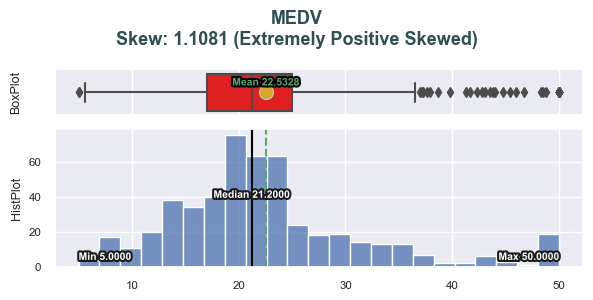

In [12]:
# Distribution of MEDV
get_feature_hist_and_boxplot(df.MEDV)

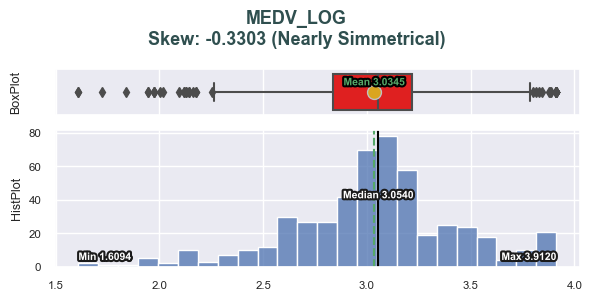

In [13]:
# As the dependent variable is sightly skewed, we will apply a log transformation on the 'MEDV' column 
# and check the distribution of the transformed column.
df['MEDV_log'] = np.log(df['MEDV'])

# Distribution of MEDV_log
get_feature_hist_and_boxplot(df.MEDV_log)

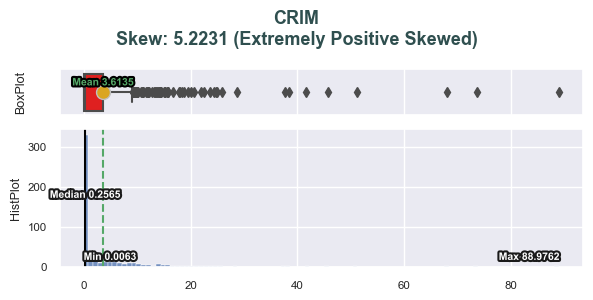

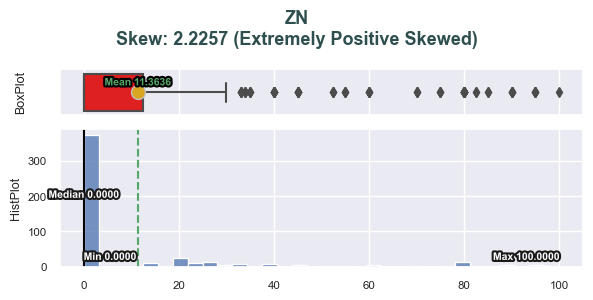

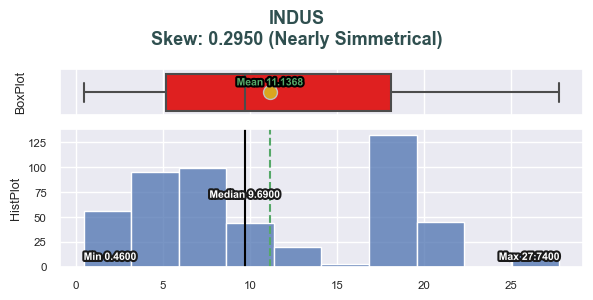

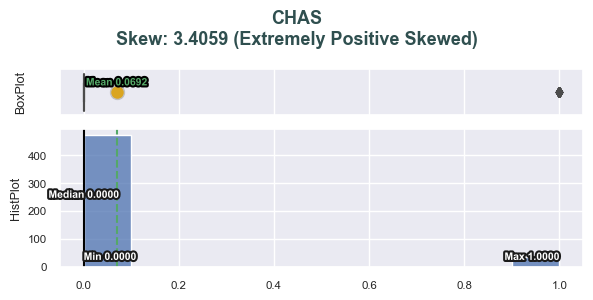

In [14]:
for col in df.columns[:4]:
    get_feature_hist_and_boxplot(df[col])

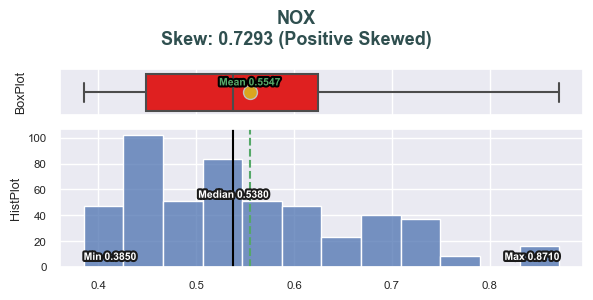

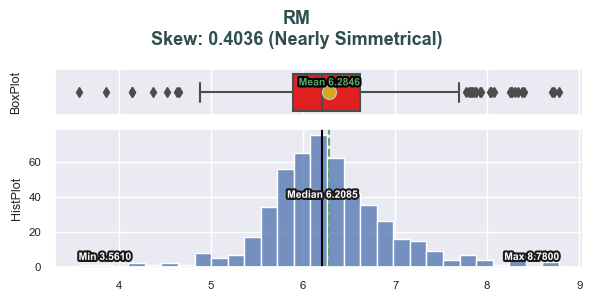

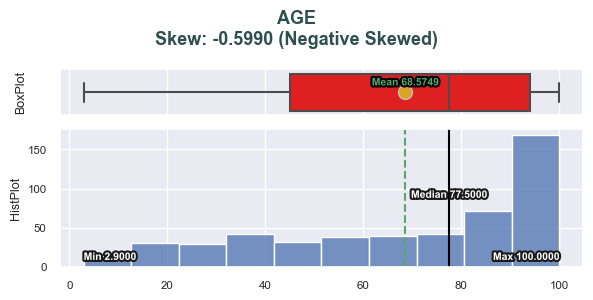

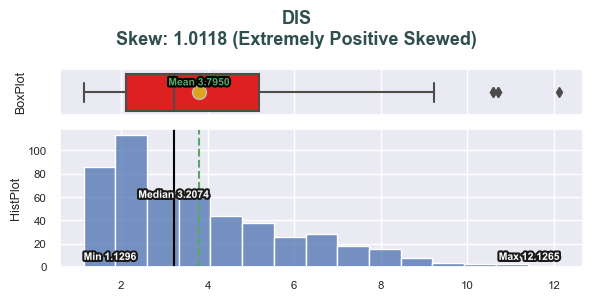

In [15]:
for col in df.columns[4:8]:
    get_feature_hist_and_boxplot(df[col])

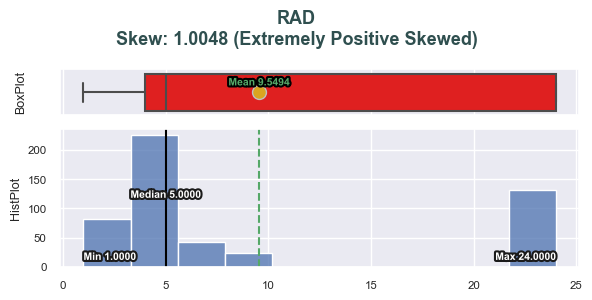

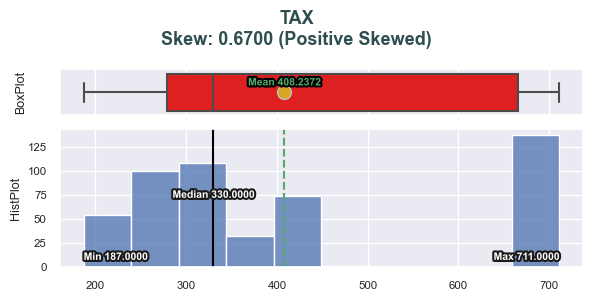

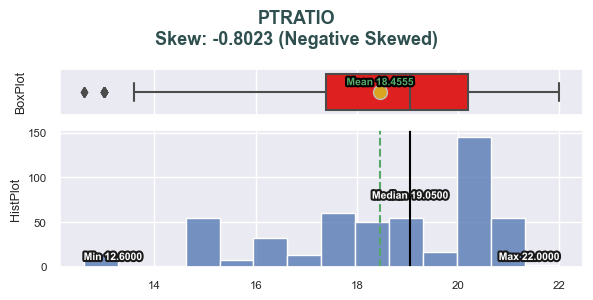

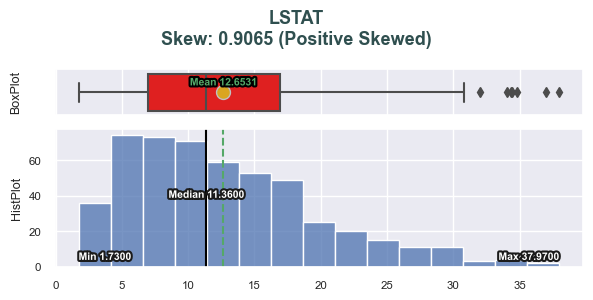

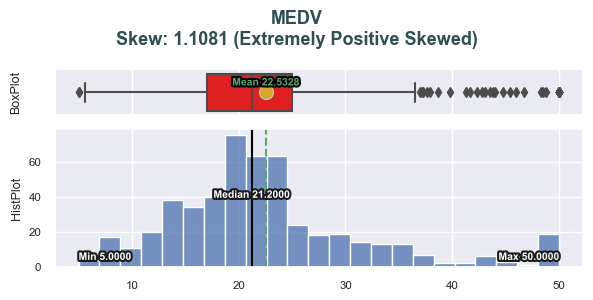

In [16]:
for col in df.columns[8:-1]:
    get_feature_hist_and_boxplot(df[col])

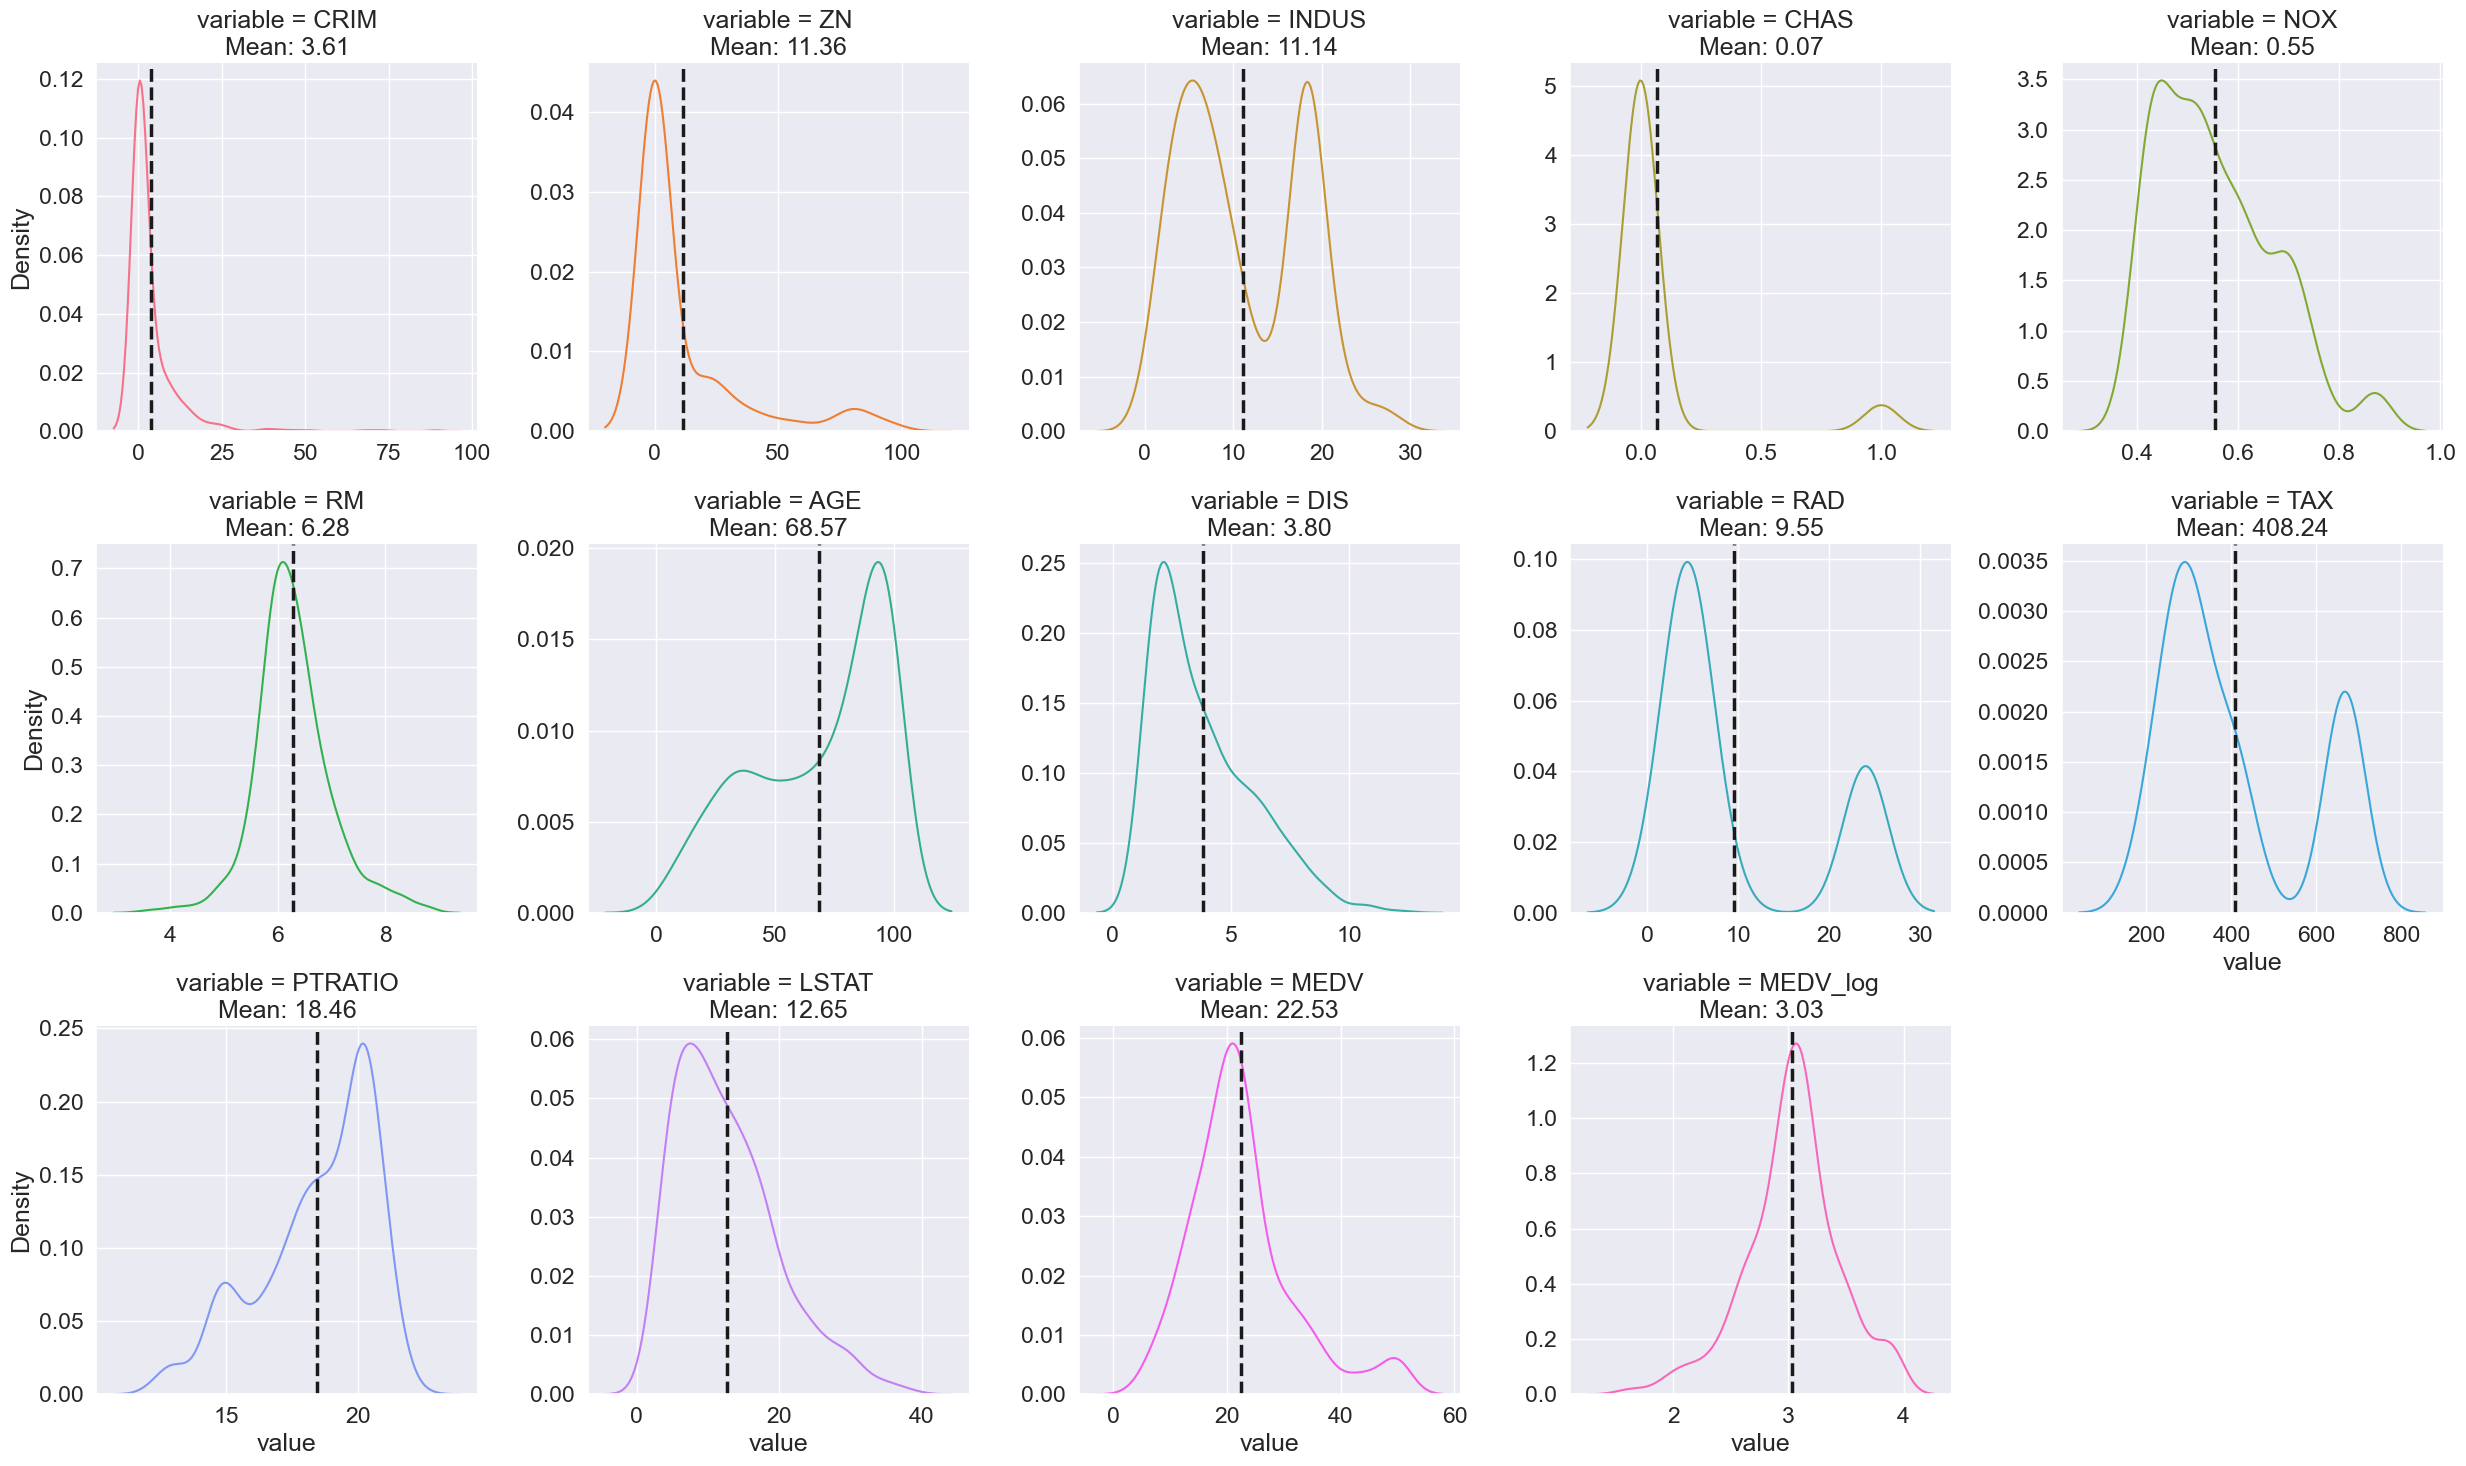

In [17]:
data_displot(df, col_wrap=5)

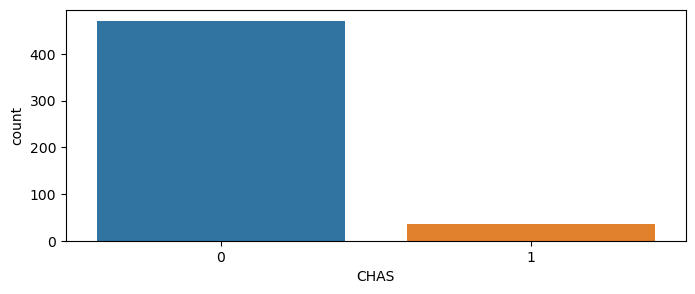

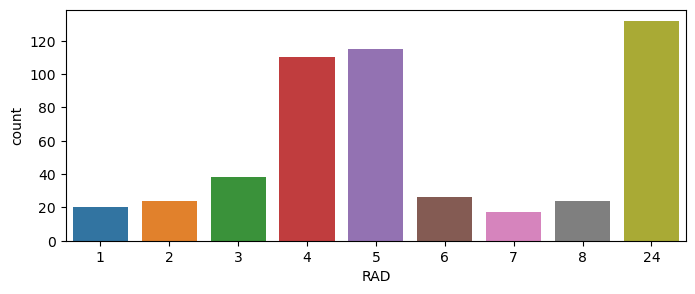

In [18]:
for col in ['CHAS', 'RAD']:
    plt.figure(figsize=(8, 3))
    sns.countplot(x=df[col])
    plt.show()

### Bivariate analysis

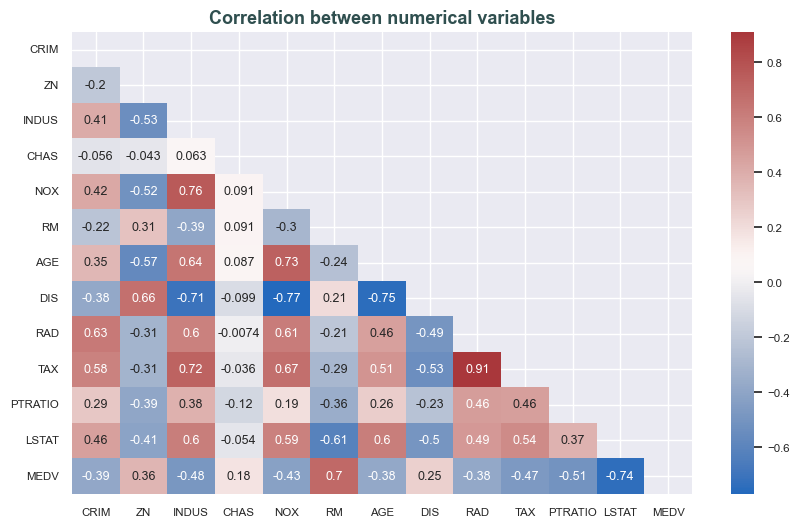

In [19]:
# Correlation heatmap
corr = get_df_correlation(df[df.columns[:-1]], tol=0.7) # Avoiding the MEDV_log
# corr = get_df_correlation(df, tol=0.7)

In [20]:
# Features with correlation > 0.7
corr

,INDUS,NOX,AGE,RAD,LSTAT
NOX,0.763651,NaN,NaN,NaN,NaN
AGE,NaN,0.73147,NaN,NaN,NaN
DIS,-0.708027,-0.76923,-0.747881,NaN,NaN
TAX,0.720760,NaN,NaN,0.910228,NaN
MEDV,NaN,NaN,NaN,NaN,-0.737663


In [21]:
# Getting the features name
features_with_higher_corr = list(set(corr.index).union(set(corr.columns)))
features_with_higher_corr

['MEDV', 'RAD', 'TAX', 'LSTAT', 'AGE', 'INDUS', 'NOX', 'DIS']

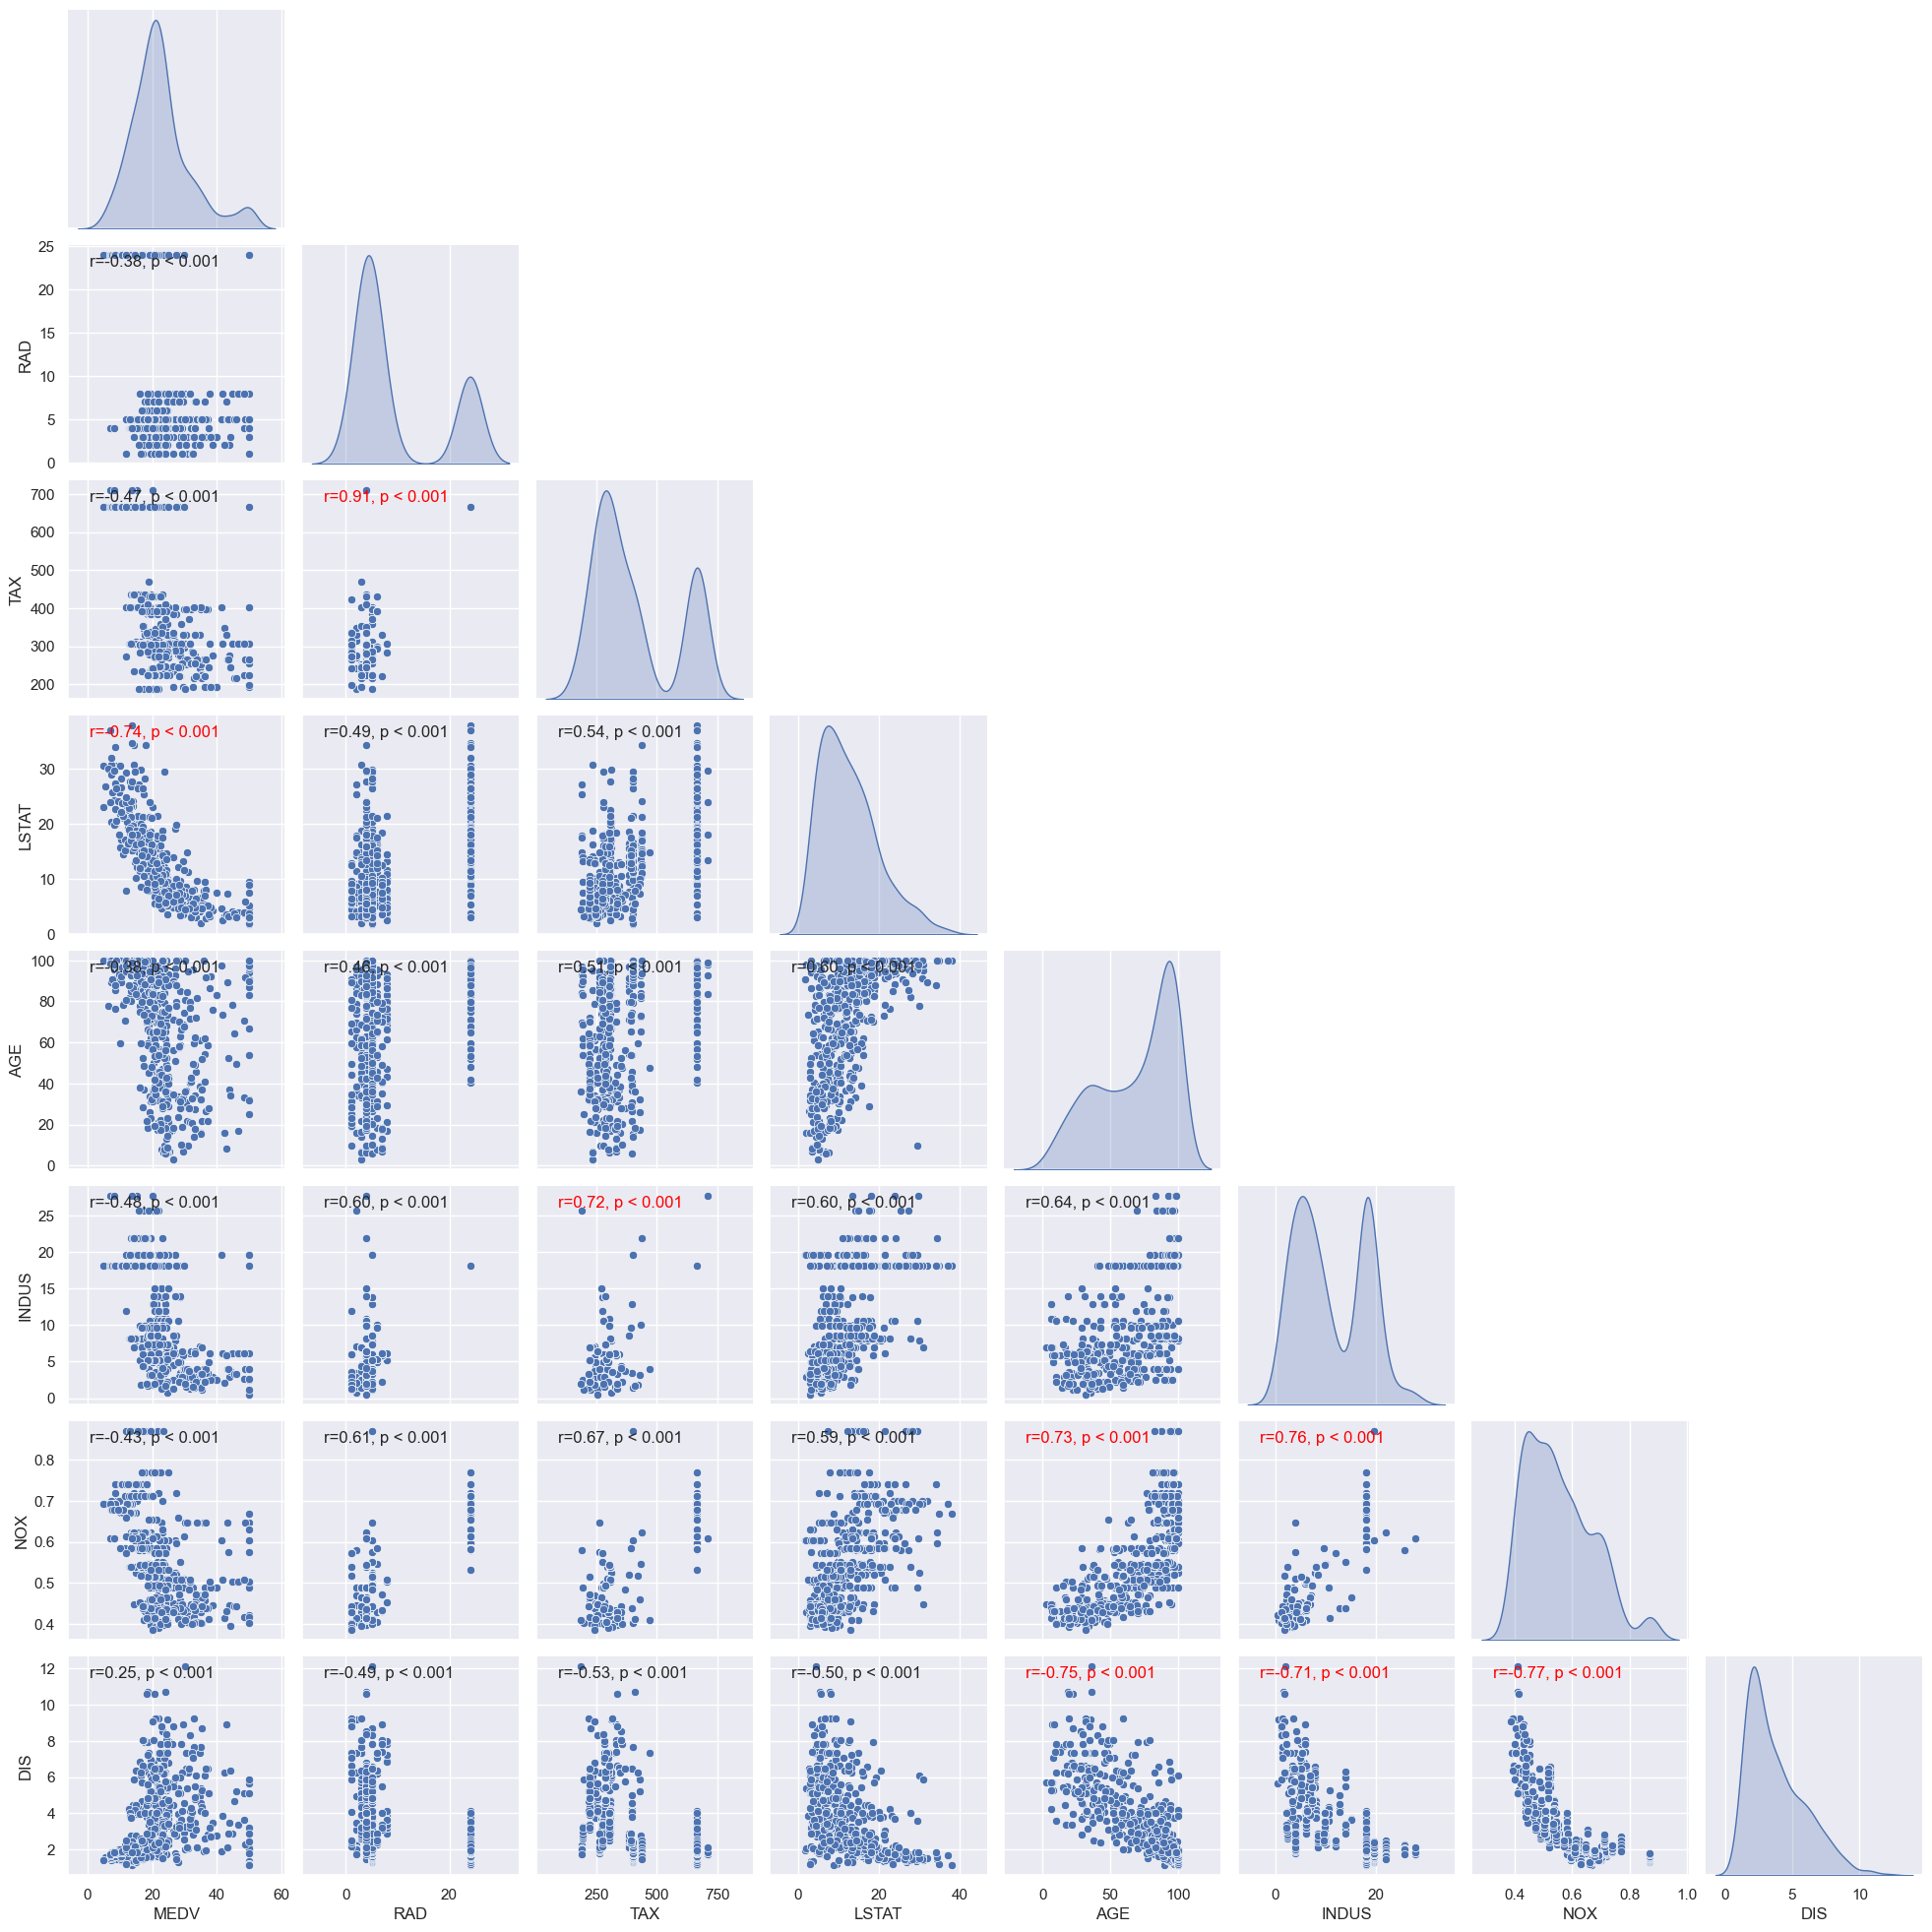

In [22]:
data_pairplot(df, features_with_higher_corr, threashold=(0.7, 0.001))

In [23]:
hihglighted_values = {q: s.dropna().to_dict() for q, s in corr.iterrows()}
hihglighted_values

{'NOX': {'INDUS': 0.7636514469209139},
 'AGE': {'NOX': 0.7314701037859592},
 'DIS': {'INDUS': -0.7080269887427675,
  'NOX': -0.7692301132258282,
  'AGE': -0.747880540868632},
 'TAX': {'INDUS': 0.7207601799515422, 'RAD': 0.9102281885331865},
 'MEDV': {'LSTAT': -0.7376627261740145}}

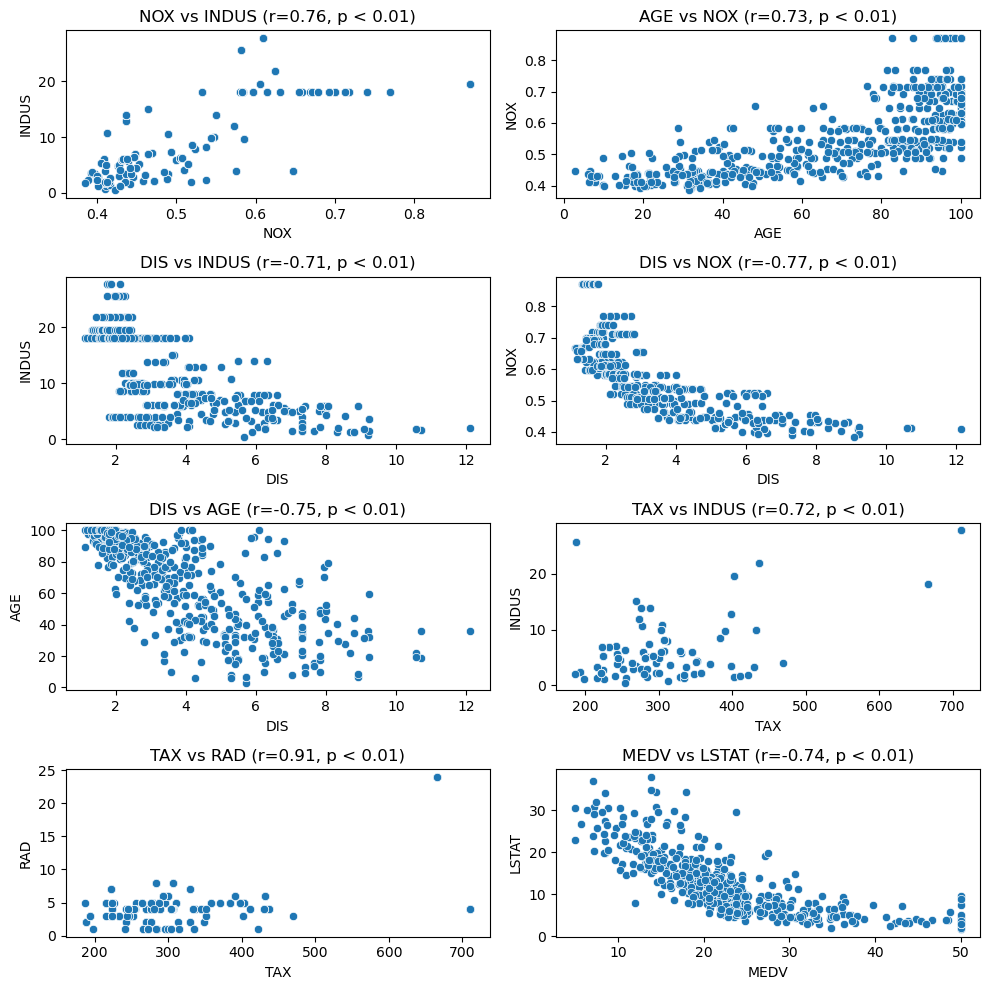

In [24]:
plt.figure(figsize = (10, 10))
i = 1
for x, s in hihglighted_values.items():
    for y, v in s.items():
        plt.subplot(4, 2, i)
        sns.scatterplot(x=x, y=y, data=df)
        (r, p) = pearsonr(df[x], df[y])
        if p<=0.01:
            p_val = f'p < 0.01' 
        else:
            p_val = f'p > 0.01'
        plt.title(f'{x} vs {y} (r={r:.2f}, {p_val})')
        i+=1

plt.tight_layout()
plt.show()

## Data Preprocessing

- Missing value treatment
- Log transformation of dependent variable if skewed
- Feature engineering (if needed)
- Outlier detection and treatment (if needed)
- Preparing data for modeling
- Any other preprocessing steps (if needed)

In [25]:
# Separate the dependent variable and indepedent variables
y = df['MEDV_log']

X = df.drop(columns = {'MEDV', 'MEDV_log'})

In [26]:
# splitting the data in 70:30 ratio of train to test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)

X_train.shape, y_train.shape

((354, 12), (354,))

## Model Building - Linear Regression

## Model Performance Check

1. How does the model is performing? Check using Rsquared, RSME, MAE, MAPE
2. Is there multicollinearity? Check using VIF
3. How does the model is performing after cross validation?

### MODEL 1

In [27]:
# Add the intercept term
X_train1 = sm.add_constant(X_train)
X_test1  = sm.add_constant(X_test)

# Train the model
model_1 = sm.OLS(y_train, X_train1).fit()

# Evaluating the model
model_performance = model_performance_regression(model_1, X_train1, y_train, X_test1, y_test, 'Model 1')
model_performance

,RMSE Train,RMSE Test,MAE Train,MAE Test,R2 Train,R2 Test,Adj. R2 Train,Adj. R2 Test,MAPE Train,MAPE Test
Model 1,0.192713,0.191963,0.140133,0.143914,0.773772,0.786246,0.765123,0.76611,4.864376,5.004389


In [28]:
# Get the model summary
# model_1.summary()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:               MEDV_log   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     97.19
Date:                Sat, 22 Jul 2023   Prob (F-statistic):          3.27e-102
Time:                        03:05:20   Log-Likelihood:                 80.575
No. Observations:                 354   AIC:                            -135.1
Df Residuals:                     341   BIC:                            -84.85
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6856      0.241     19.404      0.0

In [29]:
vif = checking_vif(X_train1)
vif

,feature,VIF,Interpretation
0,const,535.372593,Higher collinearity
1,CRIM,1.924114,No collinearity
2,ZN,2.743574,No collinearity
3,INDUS,3.999538,No collinearity
4,CHAS,1.076564,No collinearity
5,NOX,4.396157,No collinearity
6,RM,1.860950,No collinearity
7,AGE,3.150170,No collinearity
8,DIS,4.355469,No collinearity
9,RAD,8.345247,Moderate collinearity


In [30]:
pvalues = model_1.pvalues.to_frame().reset_index()
pvalues.columns = ['feature', 'pvalue']
vif_pvalues = pd.merge(left=vif, right=pvalues, on='feature')
vif_pvalues['pvalue'] = vif_pvalues.pvalue.round(5)
vif_pvalues

,feature,VIF,Interpretation,pvalue
0,const,535.372593,Higher collinearity,0.00000
1,CRIM,1.924114,No collinearity,0.00000
2,ZN,2.743574,No collinearity,0.02665
3,INDUS,3.999538,No collinearity,0.29292
4,CHAS,1.076564,No collinearity,0.00858
5,NOX,4.396157,No collinearity,0.00000
6,RM,1.860950,No collinearity,0.01396
7,AGE,3.150170,No collinearity,0.60421
8,DIS,4.355469,No collinearity,0.00000
9,RAD,8.345247,Moderate collinearity,0.00001


### MODEL 2

In [31]:
# Trying again with a second model, after dropping an insignificant variable(variables with p-value > 0.05) 
# from the above model and create the regression model again.
X_train2 = X_train1.drop(["TAX"], axis = 1)
X_test2  = X_test1.drop(["TAX"], axis = 1)

# Train the model
model_2 = sm.OLS(y_train, X_train2).fit()

# Evaluating the model
result = model_performance_regression(model_2, X_train2, y_train, X_test2, y_test, 'Model 2')
model_performance = pd.concat([model_performance, result], axis=0)
model_performance

,RMSE Train,RMSE Test,MAE Train,MAE Test,R2 Train,R2 Test,Adj. R2 Train,Adj. R2 Test,MAPE Train,MAPE Test
Model 1,0.192713,0.191963,0.140133,0.143914,0.773772,0.786246,0.765123,0.766110,4.864376,5.004389
Model 2,0.194892,0.198258,0.142894,0.149346,0.768629,0.771996,0.760487,0.752312,4.958448,5.196776


In [32]:
vif = checking_vif(X_train2)
pvalues = model_2.pvalues.to_frame().reset_index()
pvalues.columns = ['feature', 'pvalue']
vif_pvalues = pd.merge(left=vif, right=pvalues, on='feature')
vif_pvalues['pvalue'] = vif_pvalues.pvalue.round(5)
vif_pvalues

,feature,VIF,Interpretation,pvalue
0,const,532.025529,Higher collinearity,0.00000
1,CRIM,1.923159,No collinearity,0.00000
2,ZN,2.483399,No collinearity,0.15515
3,INDUS,3.270983,No collinearity,0.88260
4,CHAS,1.050708,No collinearity,0.00222
5,NOX,4.361847,No collinearity,0.00000
6,RM,1.857918,No collinearity,0.01089
7,AGE,3.149005,No collinearity,0.64520
8,DIS,4.333734,No collinearity,0.00000
9,RAD,2.942862,No collinearity,0.00025


### MODEL 3

In [33]:
# Trying again with a third model, after dropping variable not statistically significant at level α = 0.05 
# from the above model and create the regression model again.
X_train3 = X_train2.drop(["ZN", "INDUS", "AGE"], axis = 1)
X_test3  = X_test2.drop(["ZN", "INDUS", "AGE"], axis = 1)

# Train the model
model_3 = sm.OLS(y_train, X_train3).fit()

# Evaluating the model
result = model_performance_regression(model_3, X_train3, y_train, X_test3, y_test, 'Model 3')
model_performance = pd.concat([model_performance, result], axis=0)
model_performance

,RMSE Train,RMSE Test,MAE Train,MAE Test,R2 Train,R2 Test,Adj. R2 Train,Adj. R2 Test,MAPE Train,MAPE Test
Model 1,0.192713,0.191963,0.140133,0.143914,0.773772,0.786246,0.765123,0.766110,4.864376,5.004389
Model 2,0.194892,0.198258,0.142894,0.149346,0.768629,0.771996,0.760487,0.752312,4.958448,5.196776
Model 3,0.195504,0.198045,0.143686,0.151284,0.767174,0.772486,0.761082,0.758066,4.981813,5.257965


In [34]:
vif = checking_vif(X_train3)
pvalues = model_3.pvalues.to_frame().reset_index()
pvalues.columns = ['feature', 'pvalue']
vif_pvalues = pd.merge(left=vif, right=pvalues, on='feature')
vif_pvalues['pvalue'] = vif_pvalues.pvalue.round(5)
vif_pvalues

,feature,VIF,Interpretation,pvalue
0,const,526.961418,Higher collinearity,0.00000
1,CRIM,1.892679,No collinearity,0.00000
2,CHAS,1.049602,No collinearity,0.00214
3,NOX,3.528194,No collinearity,0.00000
4,RM,1.748438,No collinearity,0.00364
5,DIS,2.582254,No collinearity,0.00000
6,RAD,2.838523,No collinearity,0.00012
7,PTRATIO,1.591527,No collinearity,0.00000
8,LSTAT,2.437311,No collinearity,0.00000


## Checking Linear Regression Assumptions

1. **Mean of residuals should be 0**
2. **No Heteroscedasticity**
3. **Linearity of variables**
4. **Normality of error terms**

- In order to make statistical inferences from a linear regression model, it is important to ensure that the assumptions of linear regression are satisfied.

### **1. Check for mean residuals**

In [35]:
residuals = model_3.resid

np.mean(residuals)

-3.057190407922606e-15

**Observation:**

- The mean of residuals is very close to 0. Hence, the corresponding assumption is satisfied.

### **2. Check for homoscedasticity**

- Homoscedasticity - If the residuals are symmetrically distributed across the regression line, then the data is said to be homoscedastic.

- Heteroscedasticity- - If the residuals are not symmetrically distributed across the regression line, then the data is said to be heteroscedastic. In this case, the residuals can form a funnel shape or any other non-symmetrical shape.

- We'll use `Goldfeldquandt Test` to test the following hypothesis with alpha = 0.05:

    - Null hypothesis: Residuals are homoscedastic
    - Alternate hypothesis: Residuals have heteroscedastic

In [36]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(y_train, X_train3)
lzip(name, test)

[('F statistic', 1.0835082923425292), ('p-value', 0.30190120067668275)]

**Observation:**

- Since p-value > 0.05, we cannot reject the Null Hypothesis that the residuals are homoscedastic and the corresponding assumption is satisfied.

### **3. Linearity of variables**

It states that the predictor variables must have a linear relation with the dependent variable.

To test the assumption, we'll plot residuals and the fitted values on a plot and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x-axis.

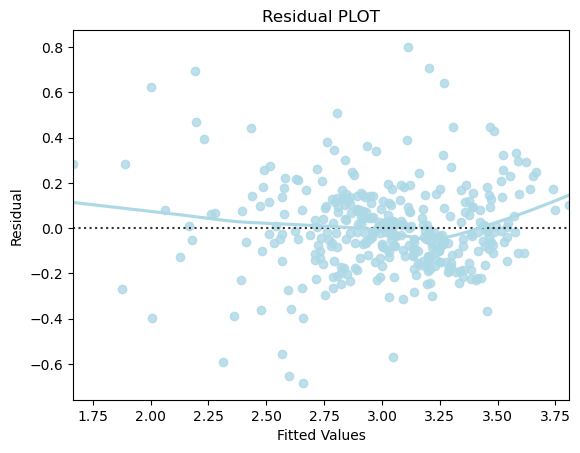

In [37]:
# Predicted values
fitted = model_3.fittedvalues

# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residuals, color = "lightblue", lowess = True)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

**Observation:**

- There is no pattern in the residual vs fitted values plot. Hence, the corresponding assumption is satisfied.

### **4. Normality of error terms**

The residuals should be normally distributed.

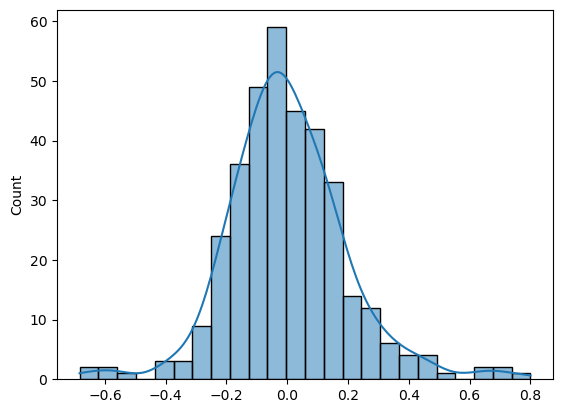

In [38]:
# Plot histogram of residuals
_ = sns.histplot(residuals, kde = True)

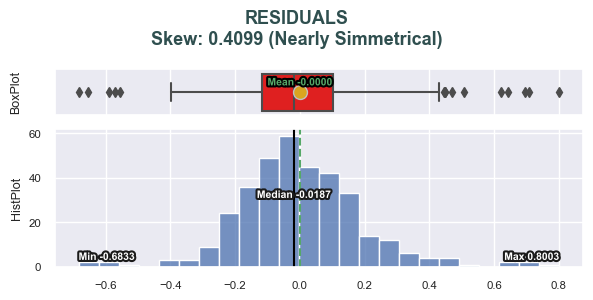

In [39]:
residuals.name = 'Residuals'
get_feature_hist_and_boxplot(residuals)

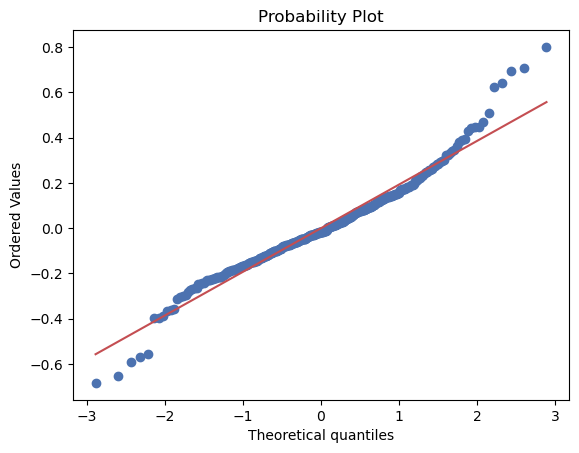

In [40]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist = "norm", plot = pylab)
plt.show()

**Observation:**

- From the above plots, the residuals seem to follow a normal distribution. Hence, the corresponding assumption is satisfied. Now, we will check the model performance on the train and test datasets.

## Final Model

### **Apply cross validation to improve the model and evaluate it using different evaluation metrics**

In [41]:
# Import the required function

from sklearn.model_selection import cross_val_score

# Build the regression model and cross-validate
linearregression = LinearRegression()                                    

cv_Score11 = cross_val_score(linearregression, X_train, y_train, cv = 10)
cv_Score12 = cross_val_score(linearregression, X_train, y_train, cv = 10, 
                             scoring = 'neg_mean_squared_error')                                  


print("RSquared: %0.3f (+/- %0.3f)" % (cv_Score11.mean(), cv_Score11.std() * 2))
print("Mean Squared Error: %0.3f (+/- %0.3f)" % (-1*cv_Score12.mean(), cv_Score12.std() * 2))

RSquared: 0.733 (+/- 0.232)
Mean Squared Error: 0.041 (+/- 0.023)


### Get model coefficients in a pandas DataFrame with column 'Feature' having all the features and column 'Coefs' with all the corresponding Coefs.

In [42]:
coef = model_3.params
pd.DataFrame({'Feature' : coef.index, 'Coefs' : coef.values})

,Feature,Coefs
0,const,4.649386
1,CRIM,-0.012500
2,CHAS,0.119773
3,NOX,-1.056225
4,RM,0.058907
5,DIS,-0.044069
6,RAD,0.007848
7,PTRATIO,-0.048504
8,LSTAT,-0.029277


## Actionable Insights and Recommendations 

- 


___